# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from PIL.XbmImagePlugin import xbm_head
from keras.src.utils.jax_layer_test import num_classes
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap

In [12]:
df = pd.read_csv('data/data.csv',sep=";")

In [27]:
# Binary target: 1 = Dropout, 0 = else
df["DropoutFlag"] = (df["Target"] == "Dropout").astype(int)

# Drop Target for correlation
corr_data = df.drop(columns=["Target"])

# Compute correlations with dropout flag
correlations = corr_data.corr(numeric_only=True)["DropoutFlag"].sort_values(key=abs, ascending=False)

print("Top correlations with Dropout:")
print(correlations.head(15))

Top correlations with Dropout:
DropoutFlag                               1.000000
Curricular units 2nd sem (grade)         -0.571792
Curricular units 2nd sem (approved)      -0.569500
Curricular units 1st sem (grade)         -0.480669
Curricular units 1st sem (approved)      -0.479112
Tuition fees up to date                  -0.429149
Age at enrollment                         0.254215
Scholarship holder                       -0.245354
Debtor                                    0.229407
Gender                                    0.203983
Application mode                          0.198458
Curricular units 2nd sem (evaluations)   -0.154999
Curricular units 2nd sem (enrolled)      -0.141515
Curricular units 1st sem (enrolled)      -0.124635
Displaced                                -0.107232
Name: DropoutFlag, dtype: float64


In [14]:
le = LabelEncoder()
y = le.fit_transform(df['Target'])
X = df.drop(columns=['Target'])

X["approval_ratio_1st"] = X["Curricular units 1st sem (approved)"] / X["Curricular units 1st sem (enrolled)"].replace(0, np.nan)
X["approval_ratio_2nd"] = X["Curricular units 2nd sem (approved)"] / X["Curricular units 2nd sem (enrolled)"].replace(0, np.nan)
X["avg_grade"] = X[["Curricular units 1st sem (grade)", "Curricular units 2nd sem (grade)"]].replace(0, np.nan).mean(axis=1)
X["total_approved"] = X["Curricular units 1st sem (approved)"] + X["Curricular units 2nd sem (approved)"]
X["total_enrolled"] = X["Curricular units 1st sem (enrolled)"] + X["Curricular units 2nd sem (enrolled)"]
X["total_approval_ratio"] = X["total_approved"] / X["total_enrolled"].replace(0, np.nan)
X = X.fillna(0)

drop_features = [
    "Marital status", "Nationality", "Daytime/evening attendance\t",
    "Educational special needs", "International", "Gender"
]
X = X.drop(columns=drop_features)

In [ ]:
# OPTIONAL/NOT NEEDED
categorical_cols = [
    "Marital status", "Application mode", "Application order", "Course",
    "Daytime/evening attendance\t", "Previous qualification", "Nationality",
    "Mother's qualification", "Father's qualification", "Mother's occupation",
    "Father's occupation", "Displaced", "Educational special needs",
    "Debtor", "Tuition fees up to date", "Gender", "Scholarship holder",
    "International"
]
numeric_cols = [
    "Previous qualification (grade)", "Admission grade", "Age at enrollment",
    "Curricular units 1st sem (credited)", "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)", "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)", "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)", "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)", "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)", "Curricular units 2nd sem (without evaluations)",
    "Unemployment rate", "Inflation rate", "GDP"
]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [23]:
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

print("Original training shape:", X_train.shape, "Balanced training shape:", X_train_sm.shape)

Original training shape: (3539, 36) Balanced training shape: (5301, 36)


In [33]:
xgb = XGBClassifier(
    n_estimators=120,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multi:softprob",
    num_class=len(le.classes_),
    eval_metric="mlogloss",
    random_state=42,
    n_jobs=-1,
)

xgb.fit(X_train_sm, y_train_sm)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=120, n_jobs=-1, num_class=3, ...)

In [34]:
print("Train accuracy:", xgb.score(X_train, y_train))
print("Test accuracy:", xgb.score(X_test, y_test))

Train accuracy: 0.8700197795987568
Test accuracy: 0.7593220338983051


In [35]:
y_pred = xgb.predict(X_test)
print(classification_report(y_test, y_pred, target_names=le.classes_))

              precision    recall  f1-score   support

     Dropout       0.83      0.71      0.77       284
    Enrolled       0.47      0.53      0.50       159
    Graduate       0.83      0.87      0.85       442

    accuracy                           0.76       885
   macro avg       0.71      0.71      0.71       885
weighted avg       0.77      0.76      0.76       885



In [39]:
# Build SHAP explainer
explainer = shap.TreeExplainer(xgb)

# Get SHAP values
shap_values = explainer.shap_values(X_test)

# Check the type/shape of shap_values
print(type(shap_values))
print(np.array(shap_values).shape)

<class 'numpy.ndarray'>
(885, 36, 3)


Dropout is encoded as: 0


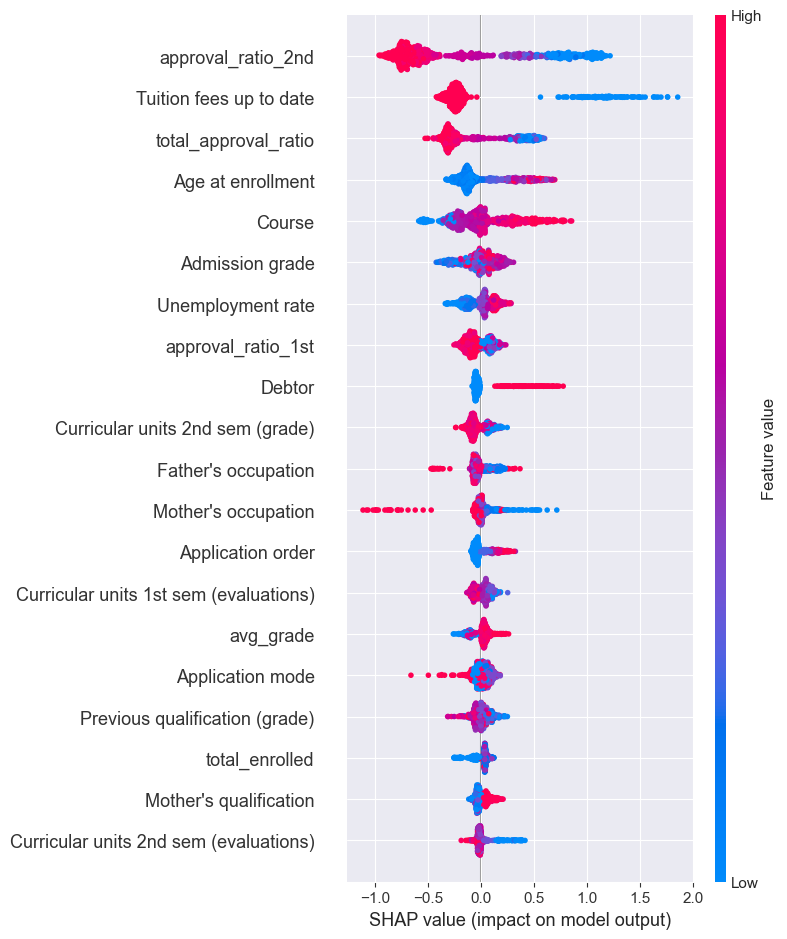

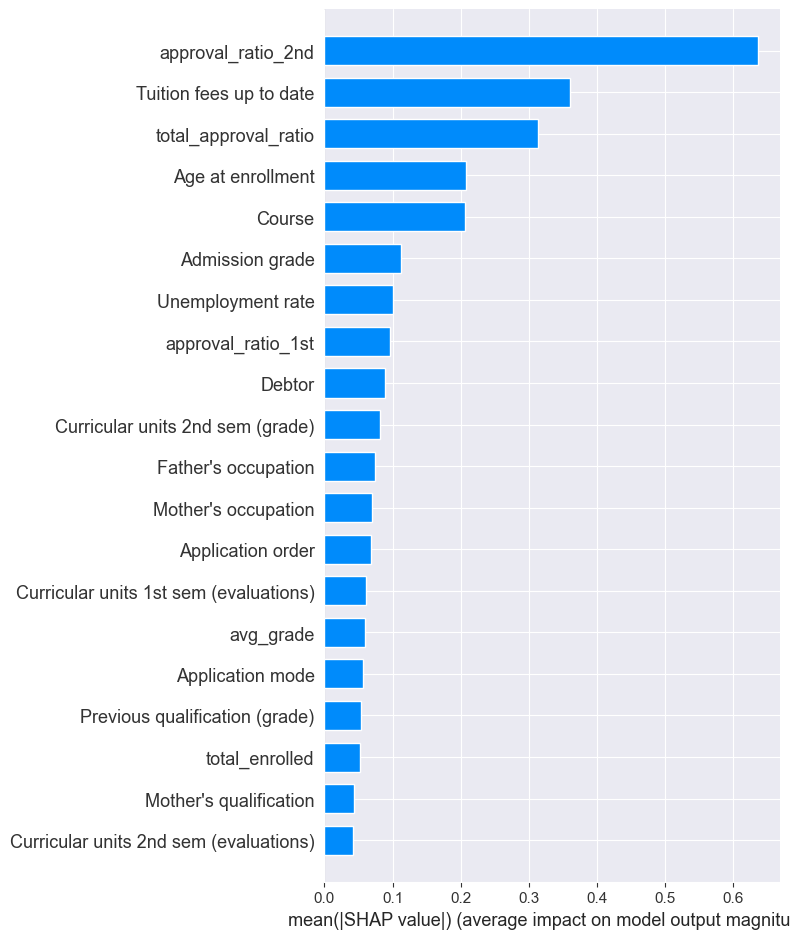

In [40]:
# Find which index is "Dropout"
dropout_idx = list(le.classes_).index("Dropout")
print("Dropout is encoded as:", dropout_idx)

# SHAP summary scatter (per-feature effect on dropout predictions)
shap.summary_plot(shap_values[:, :, dropout_idx], X_test, feature_names=X_test.columns)

# SHAP summary bar (cleaner top-10 features)
shap.summary_plot(shap_values[:, :, dropout_idx], X_test, feature_names=X_test.columns, plot_type="bar")